Yaml Loaders - utils.py


In [3]:
a = np.random.randn(20,20,3)

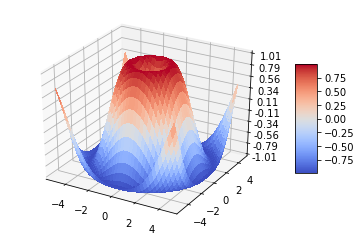

In [5]:
                    
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()       
                    
                    

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#

n_groups = 15
rects1 = ax.bar(index+bar_width,read_dram, bar_width, color='blue', error_kw=error_config,label='DRAM')
rects2 = ax.bar(index + 2.2*bar_width,read_nvm, bar_width, color='green', error_kw=error_config,label='NVM')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Average Read Size \n (in KB)',fontsize=20,fontweight='bold')
ax.legend(fontsize=20)
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')
fig.tight_layout()
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('read_avg.png', bbox_inches = 'tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

n_groups = 15
fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#


rects1 = ax.bar(index+bar_width,h0_writes[:,0], bar_width, color='red', error_kw=error_config,label='DRAM')+ax.bar(index+bar_width, h0_writes[:,1], bar_width, bottom=h0_writes[:,0], color='gold', error_kw=error_config,label='NVM')+ax.bar(index+bar_width, h0_writes[:,2], bar_width,bottom=h0_writes[:,0]+h0_writes[:,1],color='aqua', error_kw=error_config,label='Misses')
rects1 = ax.bar(index+bar_width, h0_writes[:,0]+h0_writes[:,1]+h0_writes[:,2], bar_width, color='none', error_kw=error_config,label='h=2',hatch='o')
rects2 = axpgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
matplotlib.rcParams.update(pgf_with_rc_fonts).bar(index + 2.2*bar_width,h1_writes[:,0]  , bar_width, color='red', error_kw=error_config)+ax.bar(index + 2.2*bar_width, h1_writes[:,1] , bar_width,bottom=h1_writes[:,0], color='gold', error_kw=error_config)+ax.bar(index+2.2*bar_width,h1_writes[:,2] , bar_width,bottom=h1_writes[:,0]+h1_writes[:,1],color='aqua', error_kw=error_config)
rects2 = ax.bar(index + 2.2*bar_width, h1_writes[:,0]+h1_writes[:,1]+h1_writes[:,2], bar_width, color='none',hatch='x', error_kw=error_config,label='h=1')
rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0] , bar_width, color='red',hatch='/',error_kw=error_config)+ax.bar(index + 3.4*bar_width, h2_writes[:,1] , bar_width, bottom=h2_writes[:,0], color='gold',hatch='/',error_kw=error_config)+ax.bar(index+3.4*bar_width, h2_writes[:,2], bar_width,bottom= h2_writes[:,0]+h2_writes[:,1],color='aqua', error_kw=error_config)
rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0]+h2_writes[:,1]+h2_writes[:,2], bar_width, color='none',hatch='/',error_kw=error_config,label='h=0')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Fraction of Number of Writes  \n in DRAM/NVM',fontsize=20,fontweight='bold')
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')
ax.legend(fontsize=20)
# ax.set_ylim( (pow(10,-2),pow(10,3)))
fig.tight_layout()
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('data_writes.png', bbox_inches = 'tight')
plt.show()

# Source Code 

In [1]:
%load_ext autoreload

%autoreload 2

In [56]:
import glob
import os
import sys
from collections import deque
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
import yaml
import yamlordereddictloader
from torchvision import models
from yaml import dump

from ir.handlers import handlers
from ir.trace import trace

from utils.logger import create_logger

In [109]:
# Just preload the graph for fast experiments 
# Create Graph

for name, model in models.__dict__.items():
#     print(name)
    if not name.islower() or name.startswith("__") or not callable(model):
        continue
    if "vgg11" in name and "vgg11_bn" not in name :
        inputs = torch.randn(1, 3, 299, 299)
        vgg11_graph = trace(model().eval(), inputs)
        break
        print(vgg11_graph)
#     if "resnet50" in name:
# #         model = model().eval()
#         inputs = torch.randn(1, 3, 100, 100)
#         graph = trace(model, inputs)

In [96]:
from dot import make_dot

functions AddmmBackward
functions MulBackward0
functions ReluBackward1
functions AddmmBackward
functions MulBackward0
functions ReluBackward1
functions AddmmBackward
functions ViewBackward
functions AdaptiveAvgPool2DBackward
functions MaxPool2DWithIndicesBackward
functions ReluBackward1
functions MkldnnConvolutionBackward
functions ReluBackward1
functions MkldnnConvolutionBackward
functions MaxPool2DWithIndicesBackward
functions ReluBackward1
functions MkldnnConvolutionBackward
functions ReluBackward1
functions MkldnnConvolutionBackward
functions MaxPool2DWithIndicesBackward
functions ReluBackward1
functions MkldnnConvolutionBackward
functions ReluBackward1
functions MkldnnConvolutionBackward
functions MaxPool2DWithIndicesBackward
functions ReluBackward1
functions MkldnnConvolutionBackward
functions MaxPool2DWithIndicesBackward
functions ReluBackward1
functions MkldnnConvolutionBackward
functions TBackward
functions TBackward
functions TBackward


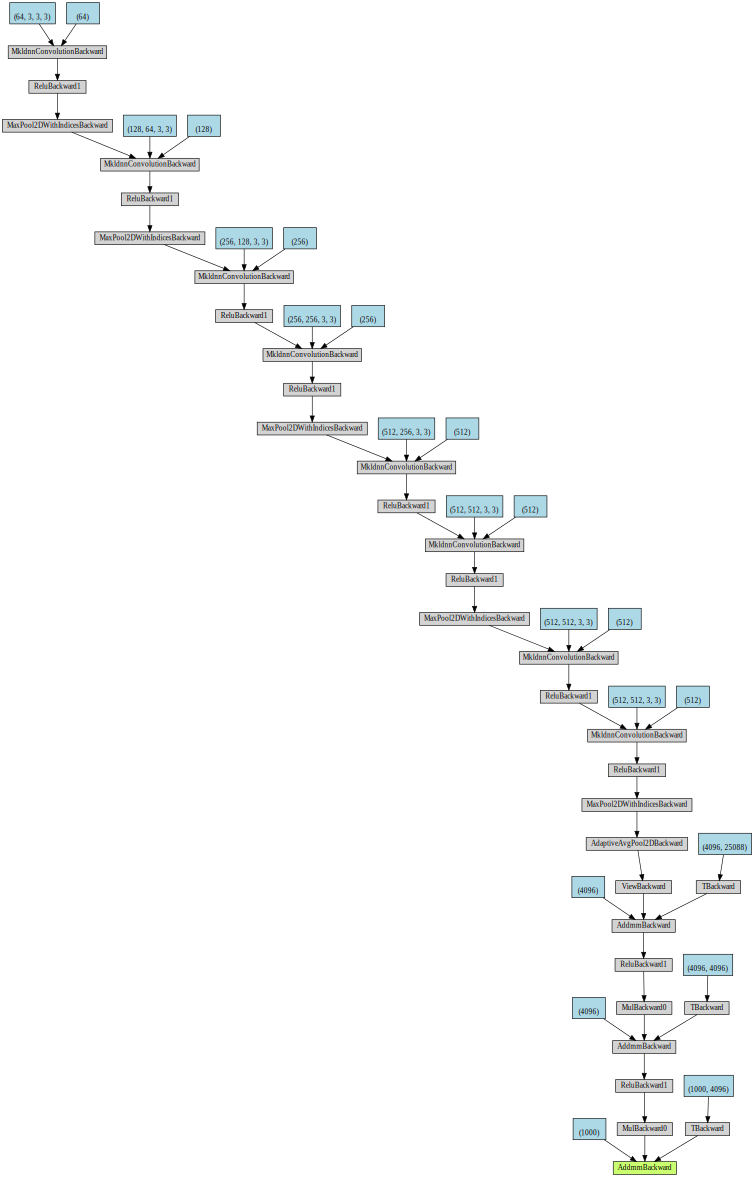

In [144]:
make_dot(model().forward(inputs))

In [4]:
from generator import Generator
from utils.visualizer import *


In [5]:
import collections
import pdb

import numpy as np
import yaml
import yamlordereddictloader

from utils.logger import create_logger


class Scheduling:
    def __init__(self, hwfile="default.yaml"):
        base_dir = "configs/"
        self.total_cycles = 0
        self.logger = create_logger("logs/stats.txt")
        self.config = self.create_config(
            yaml.load(open(base_dir + hwfile), Loader=yamlordereddictloader.Loader)
        )


In [6]:
def create_config(self, config):

    self.logger.info("Config Statistics : ")

    self.mle = config["memory_levels"]
    self.mem_energy = np.zeros((self.mle))
    self.compute_energy = 0
    self.mem_read_access = np.zeros((self.mle))
    self.mem_write_access = np.zeros((self.mle))
    self.mem_size = np.zeros((self.mle))
    self.mem_util = np.zeros((self.mle))
    self.mem_free = np.zeros((self.mle))
    self.mem_read_bw = np.zeros((self.mle))
    self.mem_write_bw = np.zeros((self.mle))
    self.internal_bandwidth_time = 0
    self.total_cycles = 0 
    self.bandwidth_idle_time = 0
    self.compute_idle_time = 0
    self.mem_size_idle_time = 0
    self.force_connectivity = False
    mm_compute = config["mm_compute"]
    vector_compute = config["vector_compute"]

    if config["mm_compute"]["class"] == "systolic_array":
        config["mm_compute_per_cycle"] = (
            ((mm_compute["size"]) ** 2) * mm_compute["N_PE"] / 2
        )
        config["comp_bw"] = (
            mm_compute["size"] * mm_compute["N_PE"] * mm_compute["frequency"] * 2
        )

        self.logger.info(
            "MM Compute per cycle : %d", config["mm_compute_per_cycle"]
        )
        self.logger.info("Compute Bandwidth Required : %d", config["comp_bw"])

    if config["mm_compute"]["class"] == "mac":
        config["mm_compute_per_cycle"] = (
            ((mm_compute["size"])) * mm_compute["N_PE"] / 2
        )
        config["comp_read_bw"] = (
            mm_compute["size"] * mm_compute["N_PE"] * mm_compute["frequency"] * 2
        )

    for i in range(self.mle):
        memory = config["memory"]["level" + str(i)]
        self.mem_read_bw[i] = (
            memory["frequency"]
            * memory["banks"]
            * memory["read_ports"]
            * memory["width"]
        )
        self.mem_write_bw[i] = (
            memory["frequency"]
            * memory["banks"]
            * memory["write_ports"]
            * memory["width"]
        )
        self.mem_size[i] = memory["size"]

        self.logger.info(
            "Memory at Level %d, Read Bandwidth %d Write Bandwidth %d",
            i,
            self.mem_read_bw[i],
            self.mem_write_bw[i],
        )

    return config

In [7]:
def run(self, graph):

    """
     Check both size, utilization and bandwidths at every node
     What about memory size that can also get exhausted ?
     So if memory size is exhausted, then have to go to a previous level and write there ?
     if any level utilization is exhausted then only the immediate memory required will be kept.
     if the memory is empty in size, but is not bandwidth, it is useless?
     Cannot do prefetching
     Read access of the next node will decrease
     Bandwidth is available but size is not?, can do prefetching, but now the memory fetches have to check, 
     whether to do fetches of the same node or a different node
     Say bandwidth at level0 is sufficient, at level1 is insufficient, then at level1 we have a bottlenecks
     slower so it will take its own time
     Do vector operations in the meantime perhaps ? 

    """

    config = self.config

    read_bw_req = []
    write_bw_req = []
    read_bw_actual = []
    write_bw_actual = []
    cycles = []
    free_cycles = []
    transferable_checkpointed_edge = []
    all_checkpointed_edge = []
    self.mem_util_log=[]
    self.mem_util_full=[]
    # Mem Fetch time of the last Nodes
#     print(self.mem_free[0], self.mem_util[0], self.mem_size[0])

    mem_free = True
    for n, node in enumerate(graph.nodes):

        # These are last level read/write accesses
        compute_expense, read_access, write_access = node.get_stats()
        self.mem_read_access[1]+=read_access-node.in_edge_mem
      
        self.logger.info(node.get_stats())
        self.mem_util[0] += node.in_edge_mem
        
        # Total Free memory
        for i in range(self.mle - 1):
            self.mem_free[i] = self.mem_size[i] - self.mem_util[i]
            
#         print("2",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        time_compute = compute_expense / config["mm_compute_per_cycle"]
        read_bw_ll = read_access / (time_compute)
        write_bw_ll = write_access / (time_compute)
        step_cycles = time_compute
        read_bw_req.append(read_bw_ll)
        write_bw_req.append(write_bw_ll)
        free_cycles.append(step_cycles)
#         print("bandwidth",read_bw_ll, write_bw_ll, step_cycles) 
        
        if self.mem_free[0] < node.mem_util:
            mem_free = False
            # node mem_util = output edge
            self.logger.info("Memory size is too low/ Memory is Full")
            self.logger.info("Node or Node memory Requirements too high")
            # Rearrange the checkpointed_nodes
            # rearrange = True

            # Is it possible now : Otherwise update the last level memory bandwidth requirements
            if(self.mem_free[0]<0):      
                step_cycles += 2*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem) + 1)*(
                   (self.mem_free[0]+node.in_edge_mem)  / self.mem_read_bw[self.mle - 1]
                ) + time_compute*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem) + 1)
                # Change this later with the number of solid total cycles
                self.mem_size_idle_time += 2*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem) + 1)*(
                   (self.mem_free[0]+node.in_edge_mem)  / self.mem_read_bw[self.mle - 1]
                ) + time_compute*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem) + 1)
                self.mem_read_access[0]+=node.in_edge_mem*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem)) 
                self.mem_write_access[0]+=node.in_edge_mem*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem)) 
        else:
            self.mem_util[0] += node.mem_util
            self.mem_free[0] -= node.mem_util
#         print("2.5",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        self.mem_util_log.append(self.mem_util[0])
        self.mem_read_access[0]+=node.mem_util
        self.mem_write_access[0]+=node.mem_util
            
        assert(self.mem_free[0] < self.mem_size[0])
        # Last level memory fetch takes more time, so that may be a bottleneck
        bandwidth_available = read_bw_ll < self.mem_read_bw[self.mle - 1]
        
        # If Bandwidth is not available : Cannot Prefetch
        if (bandwidth_available) == False:
            step_cycles += (
                read_bw_ll / self.mem_read_bw[self.mle - 1]
            - 1) * time_compute
            self.bandwidth_idle_time += (
                read_bw_ll / self.mem_read_bw[self.mle - 1]
            - 1) * time_compute

        # If memory is not free for the next node and Bandwidth is available : Move nodes back and forth
        # if(total_mem_free[0] == 0 and (bandwidth_available)):
        # for(nodes in checkpointed_nodes):
        # checkpointed but not immediate node

        # Check if memory is free and Bandwidth available : From the Data Dependence Graph, Prefetch new node

        # pdb.set_trace()
        if self.mem_free[0] > 0 and (bandwidth_available):
            print("Prefetching new nodes")
            if n < len(graph.nodes) - 1:
                if self.mem_free[0] > node.next.mem_util:
                    read_access += node.next.mem_util
                    if read_access / step_cycles < self.mem_read_bw[self.mle - 1]:
                        self.mem_util[0] += node.next.mem_util
                        self.mem_write_access[0] += node.next.mem_util
                        self.mem_free[0] -= node.next.mem_util
                        node.next.mem_util = 0
                    else:
                        read_access = self.mem_read_bw[self.mle - 1] * step_cycles
                        self.mem_util[0] += read_access - read_bw_ll * step_cycles
                        self.mem_write_access[0]+=read_access - read_bw_ll * step_cycles
                        self.mem_free[0] -= read_access - read_bw_ll * step_cycles
                        node.next.mem_util = read_access - read_bw_ll * step_cycles

                else:
                    read_access += self.mem_free[0]
                    if read_access / step_cycles < self.mem_read_bw[self.mle - 1]:
                        node.next.mem_util = node.next.mem_util - self.mem_free[0]
                        self.mem_util[0] = self.mem_size[0]
                        self.mem_free[0] = 0
                    else:
                        read_access = self.mem_read_bw[self.mle - 1] * step_cycles
                        self.mem_util[0] += read_access - read_bw_ll * step_cycles
                        self.mem_free[0] -= read_access - read_bw_ll * step_cycles
                        node.next.mem_util = read_access - read_bw_ll * step_cycles
#         print("3",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        self.mem_util_full.append(self.mem_util[0])   
        
            # TODO Consider Write bandwidth for a block read memory or Write Bandwidth  for a endurance purposes
        self.mem_util[0] -= node.in_edge_mem
#         print("4",self.mem_free[0], self.mem_util[0], self.mem_size[0])
    
        if mem_free:
            self.mem_util[0] -= node.mem_util
#         print("5",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        
        self.logger.info(
            "Node operator %r, Step Cycles %d, Read Accesses %d, Write Accesses %d ",
            node.operator,
            step_cycles,
            read_access,
            write_access,
        )
        self.total_cycles += step_cycles
        cycles.append(step_cycles)
        read_bw_actual.append(read_access / step_cycles)
        write_bw_actual.append(write_access / step_cycles)
#         print("actual",read_access / step_cycles, write_access / step_cycles, step_cycles)
#     print("The total cycles are ", self.total_cycles)
    return read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles

In [8]:
Scheduling.create_config = create_config
Scheduling.run = run

In [9]:
def runner(graph_set):
    """
    Runs the Input Graph
    """
    
    """
    Scheduling works in the following way :
    1. Start with a given/random Hardware point -> Nodes of the graph are scheduled (prefetching)
    
    2. Do the Scheduling with that Point -> Mapping stops here -> Further evaluation is done using accelergy 
    (with values taken from ERT/ART) -> If values not available -> Use plugins for generating these values 
    
    3. Log bottlenecks and work on a different Hardware point -> do this till some realistically
    max, min values are not violated -> Values/Analyses for a different/unavailable point will require full 
    From the technology node set, generate the reference tables using plugins integration of plugins -> 
    Currently using a table at 40nm.   
    
    4. Optimization metric (time/area/energy) of execution in various components, 
    then optimize the metric of execution and take decisions accordingly 
    
    5. Optimize over different workloads ?
    
    """
    
    num_iterations = 10
    generator = Generator()
    for graph in graph_set:
        scheduler = Scheduling()
        read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles = scheduler.run(graph)
        read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
#         bandwidth_bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes)
#         cycles_bar_graph("cycles.png", cycles, free_cycles, graph.nodes)
#         mem_util_bar_graph("mem_util.png",scheduler.mem_util_full/scheduler.mem_size[0],scheduler.mem_util_log/scheduler.mem_size[0], graph.nodes)
        
        for i in range(num_iterations):
            nexthw = generator.findnext(scheduler)
            generator.writehwfile(nexthw, str(i) + "hw.yaml")
            scheduler.create_config(nexthw)
            read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles = scheduler.run(graph)
            read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
#             bandwidth_bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes, cycles)
            generator.save_statistics(scheduler)
            

In [10]:
# Have to plot memory bandwidth utilization over time

In [146]:
runner([graph])

Prefetching new nodes
Prefetching new nodes


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
print(vgg11_graph.nodes)

In [14]:
from transformers import BertModel, BertConfig

/home/khushal/anaconda2/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
configuration = BertConfig()

model = BertModel(configuration)

In [40]:
model.config

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [147]:
tokenizer = torch.hub.load('huggingface/pytorch-pretrained-BERT', 'tokenizer', 'bert-base-cased', do_basic_tokenize=False)

# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

### Get the hidden states computed by `bertModel`
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
segments_tensors = torch.tensor([segments_ids])
tokens_tensor = torch.tensor([indexed_tokens])

model = torch.hub.load('huggingface/pytorch-pretrained-BERT', 'model', 'bert-base-cased')
# model.eval()

# model(tokens_tensor, segments_tensors)

Using cache found in /home/khushal/.cache/torch/hub/huggingface_pytorch-pretrained-BERT_master
Using cache found in /home/khushal/.cache/torch/hub/huggingface_pytorch-pretrained-BERT_master


In [63]:
graph = trace(model, (tokens_tensor, segments_tensors))

In [64]:
graph

transformers.modeling_bert.BertModel (
	%input.1: long[1, 16],
	%attention_mask: long[1, 16],
	%2: float[28996, 768],
	%3: float[512, 768],
	%4: float[2, 768],
	%5: float[768],
	%6: float[768],
	%7: float[768, 768],
	%8: float[768],
	%9: float[768, 768],
	%10: float[768],
	%11: float[768, 768],
	%12: float[768],
	%13: float[768, 768],
	%14: float[768],
	%15: float[768],
	%16: float[768],
	%17: float[3072, 768],
	%18: float[3072],
	%19: float[768, 3072],
	%20: float[768],
	%21: float[768],
	%22: float[768],
	%23: float[768, 768],
	%24: float[768],
	%25: float[768, 768],
	%26: float[768],
	%27: float[768, 768],
	%28: float[768],
	%29: float[768, 768],
	%30: float[768],
	%31: float[768],
	%32: float[768],
	%33: float[3072, 768],
	%34: float[3072],
	%35: float[768, 3072],
	%36: float[768],
	%37: float[768],
	%38: float[768],
	%39: float[768, 768],
	%40: float[768],
	%41: float[768, 768],
	%42: float[768],
	%43: float[768, 768],
	%44: float[768],
	%45: float[768, 768],
	%46: float[768],
	%4

In [116]:
import numpy as np
import pandas as pd
d = pd.read_csv('tables/sram.csv')
a = np.array(d)

input = a[:,:3]
# output = a[:,3:]


In [53]:
d = pd.read_csv('plugins/cacti/bus_width.out')


d = d.drop(d.columns[[0,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]], axis=1)

d = d.drop(' Associativity',1)
d = d.drop(' Dynamic search energy (nJ)',1)

In [45]:
# d

In [55]:
a= np.array(d)

np.savetxt('bus.csv',a, fmt='%.18e', delimiter=',')



In [ ]:
bar_graph("read_dummy.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes)


In [46]:
# print(input)

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
base_dir = "figures/"
error_config = {"ecolor": "0.3"}
index = np.arange((len(var1)))
#     plt.axhline(y=var3, color="black", linestyle="-", label="Limit", linewidth=6)
ax.bar(
    index,
    var1,
    bar_width,
    color="blue",
    error_kw=error_config,
    label="",
)
# ax.bar(
#     index + 2 * bar_width,
#     var2,
#     bar_width,
#     color="red",
#     error_kw=error_config,
#     label="",
# )
ax.legend(fontsize=20)
plt.yscale("log")
ax.set_xticks(index)
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=80)
plt.rc("xtick", labelsize=20)  # fontsize of the tick labels
plt.rc("ytick", labelsize=20)
ax.set_ylabel("Read Bandwidth", fontsize=20, fontweight="bold")
ax.set_xlabel("Graph Nodes", fontsize=20, fontweight="bold")
fig.tight_layout()
plt.savefig(base_dir + "sram.png", bbox_inches="tight")
plt.show()

name: diannao
    technology: 40nm
    
    
local:
    compute:
        name       : MACs
            class      : mac
            attributes :            
            instances       : 256
            meshX           : 16
            word-bits       : 16

    memory: 
        name       : DRAM
            class      : DRAM
            attributes :
            instances       : 1
            word-bits       : 16
  
        name       : OutputBuffer
            class      : SRAM
            attributes :
            entries         : 1024  # 64 * 16 = 1024
            instances       : 1
            meshX           : 1
            word-bits       : 16
            block-size      : 16
            read_bandwidth  : 16 # words/cycle
            write_bandwidth : 16 # words/cycle

        name       : InputBuffer
            class      : SRAM
            attributes :
            entries         : 1024 # 64 * 16 = 1024
            instances       : 1
            meshX           : 1
            word-bits       : 16
            block-size      : 16
            read_bandwidth  : 16 # words/cycle
            write_bandwidth : 16 # words/cycle

        name       : PsumRegFile
            class      : regfile
            attributes :
            entries         : 1
            instances       : 16
            meshX           : 16
            word-bits       : 16
            cluster-size    : 16
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle
            
        name       : WeightBuffer
            class      : regfile
            attributes :
            entries         : 64
            instances       : 256
            meshX           : 16
            word-bits       : 16
            cluster-size    : 256
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle
    noc:



In [232]:
mem_table = np.array(pd.read_csv("tables/sram.csv", header=None))
a = mem_table[np.where(mem_table[:, 1] == 4)]
a = a[np.where(a[:, 2] == 32)]